In [39]:
from numpy import *
%matplotlib inline

In [40]:
def loadSimpData():
    datMat = matrix([[ 1. ,  2.1],[ 2. , 1.1], [ 1.3, 1. ], [1., 1.], [2., 1.]])
    classLabels = [1.0, 1.0, -1.0, -1.0, 1.0]
    return datMat,classLabels

In [41]:
datMat,classLabels=loadSimpData()

In [42]:
def stumpClassify(dataMatrix,dimen,threshVal,threshIneq):#决策树分类
    retArray=ones((shape(dataMatrix)[0],1))
    if threshIneq=='lt':
        retArray[dataMatrix[:,dimen]<=threshVal]=-1.0
    else:
        retArray[dataMatrix[:,dimen]>threshVal]=1.0
    return retArray

In [43]:
#iterate over all of the possible inputs to stumpClassify() and find the best decision stump for our dataset
def buildStump(dataArr,classLabels,D):
    dataMatrix=mat(dataArr);labelMat=mat(classLabels).T
    m,n=shape(dataMatrix)
    numSteps=10.0;bestStump={};bestClasEst=mat(zeros((m,1)))
    minError=inf
    for i in range(n):#遍历所有特征
        rangeMin=dataMatrix[:,i].min();rangeMax=dataMatrix[:,i].max()
        stepSize=(rangeMax-rangeMin)/numSteps#步长
        for j in range(-1,int(numSteps)+1):
            for inequal in ['lt','gt']:
                threshVal=rangeMin+float(j)*stepSize
                predictedVals=stumpClassify(dataMatrix,i,threshVal,inequal)
                errArr=mat(ones((m,1)))
                errArr[predictedVals==labelMat]=0
                weightedError=D.T*errArr#基于权重计算错误
                if weightedError<minError:#寻找最小错误
                    minError=weightedError
                    bestClasEst=predictedVals.copy()
                    bestStump['dim']=i
                    bestStump['thresh']=threshVal
                    bestStump['ineq']=inequal
    return bestStump,minError,bestClasEst

In [44]:
def adaBoostTrainDS(dataArr,classLabels,numIt=40):
    weakClassArr=[]
    m=shape(dataArr)[0]
    D=mat(ones((m,1))/m)
    aggClassEst=mat(zeros((m,1)))#he aggregate estimate of the class for every data point
    for i in range(numIt):
        bestStump,error,classEst=buildStump(dataArr,classLabels,D)
        print "D:",D.T
        alpha=float(0.5*log((1.0-error)/max(error,1e-16)))#make sure you don’t have a divide-by-zero error in the case where there’s no error
        bestStump['alpha']=alpha
        weakClassArr.append(bestStump)
        print "classEst: ",classEst.T
        expon=multiply(-1*alpha*mat(classLabels).T,classEst)
        D=multiply(D,exp(expon))
        D=D/D.sum()
        aggClassEst+=alpha*classEst
        print "aggClassEst: ",aggClassEst.T
        aggErrors=multiply(sign(aggClassEst)!=mat(classLabels).T,ones((m,1)))
        errorRate=aggErrors.sum()/m
        print "total error: ",errorRate,"\n"
        if errorRate==0.0:
            break
    return weakClassArr,aggClassEst
        

In [45]:
classifierArray=adaBoostTrainDS(datMat,classLabels,9)

D: [[ 0.2  0.2  0.2  0.2  0.2]]
classEst:  [[-1.  1. -1. -1.  1.]]
aggClassEst:  [[-0.69314718  0.69314718 -0.69314718 -0.69314718  0.69314718]]
total error:  0.2 

D: [[ 0.5    0.125  0.125  0.125  0.125]]
classEst:  [[ 1.  1. -1. -1. -1.]]
aggClassEst:  [[ 0.27980789  1.66610226 -1.66610226 -1.66610226 -0.27980789]]
total error:  0.2 

D: [[ 0.28571429  0.07142857  0.07142857  0.07142857  0.5       ]]
classEst:  [[ 1.  1.  1.  1.  1.]]
aggClassEst:  [[ 1.17568763  2.56198199 -0.77022252 -0.77022252  0.61607184]]
total error:  0.0 



In [46]:
classifierArray

([{'alpha': 0.6931471805599453, 'dim': 0, 'ineq': 'lt', 'thresh': 1.3},
  {'alpha': 0.9729550745276565, 'dim': 1, 'ineq': 'lt', 'thresh': 1.0},
  {'alpha': 0.8958797346140273,
   'dim': 0,
   'ineq': 'lt',
   'thresh': 0.90000000000000002}],
 matrix([[ 1.17568763],
         [ 2.56198199],
         [-0.77022252],
         [-0.77022252],
         [ 0.61607184]]))

In [47]:
def adaClassify(datToClass,classifierArr):
    dataMatrix=mat(datToClass)#要分类的数据
    m=shape(dataMatrix)[0]
    aggClassEst=mat(zeros((m,1)))
    for i in range(len(classifierArr)):#遍历所有弱分类器
        classEst=stumpClassify(dataMatrix,classifierArr[i]['dim'],classifierArr[i]['thresh'],classifierArr[i]['ineq'])
        aggClassEst+=classifierArr[i]['alpha']*classEst
        print aggClassEst
    return sign(aggClassEst)
        

In [48]:
def plotROC(predStrengths,classLabels):
    import matplotlib.pyplot as plt
    cur=(1.0,1.0)
    ySum=0.0#AUC
    numPosClas=sum(array(classLabels)==1.0)#the number of positive instances 
    yStep=1/float(numPosClas)
    xStep=1/float(len(classLabels)-numPosClas)
    sortedIndicies=predStrengths.argsort()#the sorted index
    fig=plt.figure()
    fig.clf()
    ax=plt.subplot(111)
    for index in sortedIndicies.tolist()[0]:
        if classLabels[index]==1.0:
            delX=0;delY=yStep;
        else:
            delX=xStep;delY=0;
            ySum+=cur[1]
        ax.plot([cur[0],cur[0]-delX],[cur[1],cur[1]-delY],c='b')
        cur=(cur[0]-delX,cur[1]-delY)
    ax.plot([0,1],[0,1],'b--')
    plt.xlabel('False Positive Rate');plt.ylabel('True Positive Rate')
    plt.title('ROC curve for AdaBoost Horse Colic Detection System')
    ax.axis([0,1,0,1])
    plt.show()
    print "the Area Under the Curve is: ",ySum*xStep

In [49]:
datArr,labelArr = loadDataSet('horseColicTraining2.txt')

In [50]:
classifierArray,aggClassEst =adaBoostTrainDS(datArr,labelArr,10)

D: [[ 0.00334448  0.00334448  0.00334448  0.00334448  0.00334448  0.00334448
   0.00334448  0.00334448  0.00334448  0.00334448  0.00334448  0.00334448
   0.00334448  0.00334448  0.00334448  0.00334448  0.00334448  0.00334448
   0.00334448  0.00334448  0.00334448  0.00334448  0.00334448  0.00334448
   0.00334448  0.00334448  0.00334448  0.00334448  0.00334448  0.00334448
   0.00334448  0.00334448  0.00334448  0.00334448  0.00334448  0.00334448
   0.00334448  0.00334448  0.00334448  0.00334448  0.00334448  0.00334448
   0.00334448  0.00334448  0.00334448  0.00334448  0.00334448  0.00334448
   0.00334448  0.00334448  0.00334448  0.00334448  0.00334448  0.00334448
   0.00334448  0.00334448  0.00334448  0.00334448  0.00334448  0.00334448
   0.00334448  0.00334448  0.00334448  0.00334448  0.00334448  0.00334448
   0.00334448  0.00334448  0.00334448  0.00334448  0.00334448  0.00334448
   0.00334448  0.00334448  0.00334448  0.00334448  0.00334448  0.00334448
   0.00334448  0.00334448  0.003344

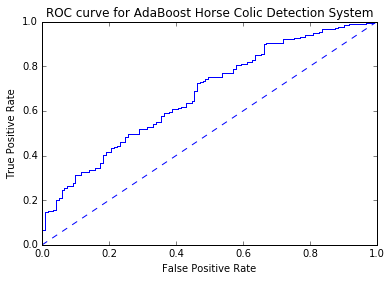

the Area Under the Curve is:  0.675735908627


In [51]:
plotROC(aggClassEst.T,labelArr)